In [2]:
!pip install textstat
!pip install tensorflow
!pip install keras
!pip install datasets
!pip install transformers

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import nltk
from nltk.stem.porter import *
import string
import re
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import random

path_to_file = "hatespeech_data_clean_text_for_bert.csv"

data = pd.read_csv(path_to_file,encoding='latin-1')

train, test= train_test_split(data,test_size=0.2, random_state=25)

train.to_csv('train.csv')
test.to_csv('test.csv')
data = load_dataset('csv',data_files={'train': 'train.csv', 'test': 'test.csv'})

Using custom data configuration default-5aa2c953f70f488e


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/4gTraders/.cache/huggingface/datasets/csv/default-5aa2c953f70f488e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from gensim.utils import pickle
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from pickle import dumps
import pickle
d={...}
d=pickle.dumps(d)



# Creating a embedding matrix
load_pretrained = False
embedding_dimension = 100

if load_pretrained:
    with open('data_for_bert_50_50.csv', 'rb') as file_in:
        model = pickle.load(file_in)
else:
    model = Word2Vec([tweet.split() for tweet in data["train"]["tweet"]], min_count = 2, vector_size = embedding_dimension,
                     window = 10, sg = 1)
    with open('data_for_bert_50_50.csv', 'wb') as file_out:
        pickle.dump(model, file_out)

# tokenize each tweet in dataset
max_vocab_size = len(model.wv.index_to_key)
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(data["train"]["tweet"])


In [42]:
# create embedding matrix where each row corresponds to a vector for a word
embedding_matrix = np.zeros([max_vocab_size + 1, embedding_dimension])



In [43]:
# convert tweets to index sequence vectors
X_train_nn = tokenizer.texts_to_sequences(data["train"]["tweet"])
X_test_nn = tokenizer.texts_to_sequences(data["test"]["tweet"])
max_sequence_length = np.array([len(sequence) for sequence in X_train_nn]).max()

# pad index sequence vectors so they all have same length
X_train_nn = pad_sequences(X_train_nn, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
X_test_nn = pad_sequences(X_test_nn, maxlen = max_sequence_length, padding = 'post', truncating = 'post')

# create hate speech label matrix y
y_train_nn = to_categorical(data["train"]["label"])
y_test_nn = to_categorical(data["test"]["label"])

In [44]:
y_test_nn.shape

(4957, 2)

In [5]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(19826, 4)


,Unnamed: 0.1,Unnamed: 0,tweet,label
0,20694,20694,sexy ass yellow bone,0
1,5697,5697,catleesh i have small pussy size plugs,0
2,19767,19767,rt TAG aw y'all some hoes hating on that girl ...,0
3,22656,22656,when chief keef said i aint done turning up bitch,0
4,9848,9848,hoes always tryna say they look like a celebri...,0


In [7]:
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

(4957, 4)


,Unnamed: 0.1,Unnamed: 0,tweet,label
0,22425,22425,vine is filled with pussy lol smh,0
1,18144,18144,rt TAG TAG can jump into first place tonight i...,0
2,20085,20085,rt TAG TAG i have a pink fuzzy one amp a silky...,0
3,22820,22820,who the hell taught you how to fuck bitch toot...,0
4,9310,9310,fuck you niggah i'm cold amp my aunts said no ...,0


In [47]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

0    18660
1     1166
Name: label, dtype: int64

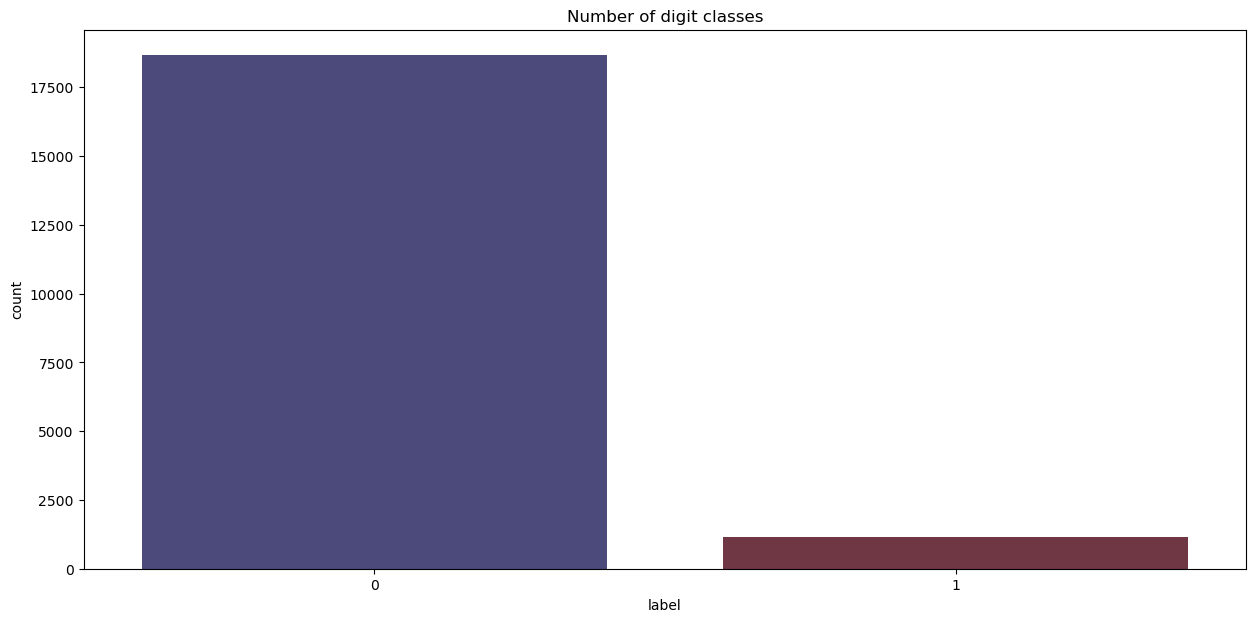

In [49]:
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

In [50]:
# Split the train and the validation set for the fitting


from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)


x_train shape (17843, 3)
x_test shape (1983, 3)
y_train shape (17843,)
y_test shape (1983,)


In [9]:
filepath_dict = pd.read_excel("Hate Speech Roman Urdu (HS-RU-20).xlsx")
print(filepath_dict)


                                             Sentence  \
0   kya mein bhooka hon? kutia ab tum ney ye pooch...   
1   khawateen ghaas ki tarah hain, inhen baqaidagi...   
2   aik aurat ke tor par aap ko apne ghar ki safai...   
3                     Afghani dehshat gard hotay hain   
4                     tamam sarkari hukkaam chor hain   
..                                                ...   
74  Tharki larky college k bahir larkiyon ko tung ...   
75  Christchurch mein firing sirf ka nishana sirf ...   
76  Molana siyasat kren, mazhabi card istemaal na ...   
77  India mein khwateen k sath rape cases mein iza...   
78        saarfeen k liye bijli mehengi kr di gai hai   

   Neutral (N) / Hostile (H)  
0                          H  
1                          H  
2                          N  
3                          H  
4                          H  
..                       ...  
74                         H  
75                         H  
76                         H  
77   

In [10]:
filepath_dict.head()

,Sentence,Neutral (N) / Hostile (H)
0,kya mein bhooka hon? kutia ab tum ney ye pooch...,H
1,"khawateen ghaas ki tarah hain, inhen baqaidagi...",H
2,aik aurat ke tor par aap ko apne ghar ki safai...,N
3,Afghani dehshat gard hotay hain,H
4,tamam sarkari hukkaam chor hain,H


In [16]:
filepath_dict.tail()

,Sentence,Neutral (N) / Hostile (H)
74,Tharki larky college k bahir larkiyon ko tung ...,H
75,Christchurch mein firing sirf ka nishana sirf ...,H
76,"Molana siyasat kren, mazhabi card istemaal na ...",H
77,India mein khwateen k sath rape cases mein iza...,H
78,saarfeen k liye bijli mehengi kr di gai hai,H


In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [5]:
(train_DA, train_labels), (test_DA, test_labels) = datasets.cifar10.load_data()
train_DA, test_DA = train_DA / 255.0, test_DA / 255.0

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()
model.save('modeel')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

INFO:tensorflow:Assets written to: modeel\assets


INFO:tensorflow:Assets written to: modeel\assets


In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_DA, train_labels, epochs=3, 
                    validation_data=(test_DA, test_labels))

Epoch 1/3
1563/1563 [==============================] - 79s 50ms/step - loss: 1.5512 - accuracy: 0.4319 - val_loss: 1.2599 - val_accuracy: 0.5486
Epoch 2/3
1563/1563 [==============================] - 77s 49ms/step - loss: 1.1963 - accuracy: 0.5750 - val_loss: 1.0930 - val_accuracy: 0.6101
Epoch 3/3
1563/1563 [==============================] - 76s 49ms/step - loss: 1.0496 - accuracy: 0.6305 - val_loss: 1.0260 - val_accuracy: 0.6404


313/313 - 4s - loss: 1.0260 - accuracy: 0.6404 - 4s/epoch - 14ms/step


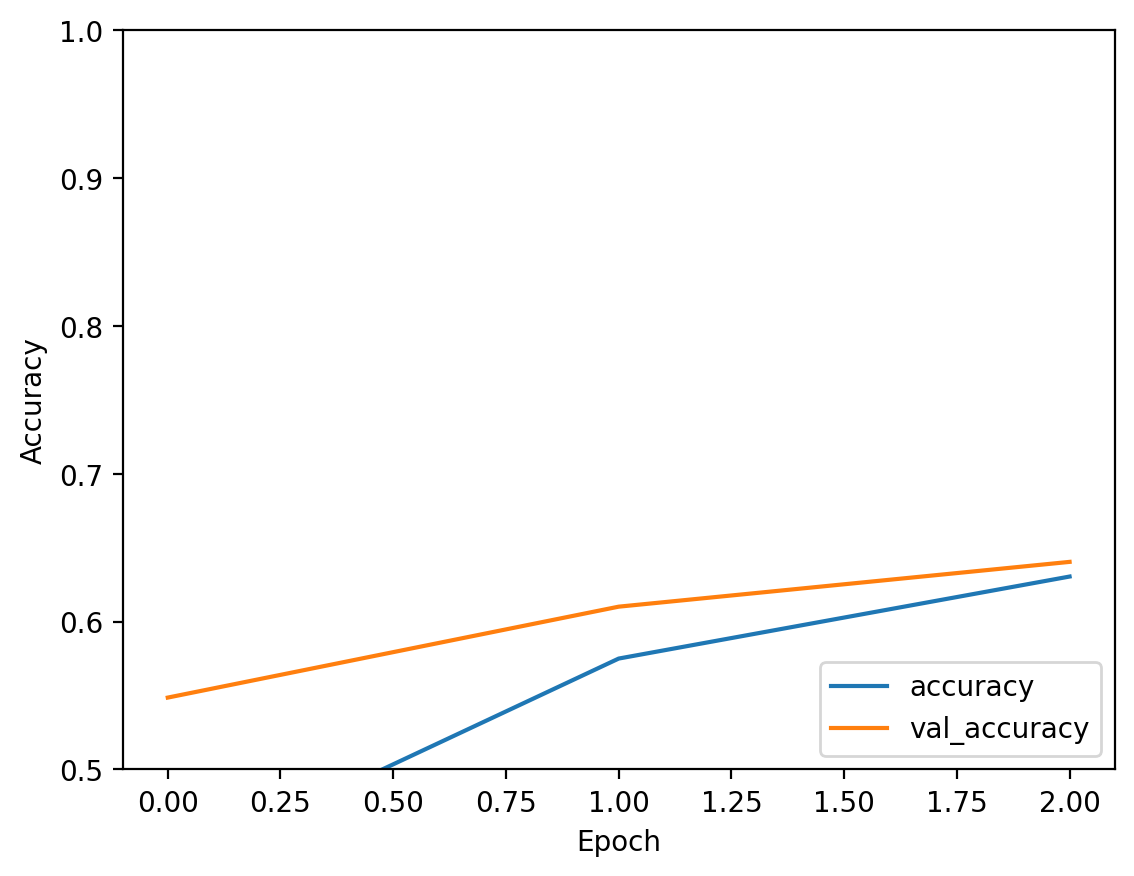

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_DA,  test_labels, verbose=2)

In [11]:
print(test_acc)

0.6403999924659729


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import  numpy as np
from keras.models import load_model
Y_test = np.argmax(test_labels, axis=1)
model_test = load_model('modeel')
y_pred = model_test.predict(test_DA)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=test_labels)

313/313 [==============================] - 5s 17ms/step


C:\Users\4gTraders\AppData\Local\Temp\ipykernel_5648\3560745079.py:14: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
C:\Users\4gTraders\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


In [14]:
print(classification_report(Y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01     10000
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.00     10000
   macro avg       0.12      0.00      0.00     10000
weighted avg       1.00      0.00      0.01     10000



C:\Users\4gTraders\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\4gTraders\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\4gTraders\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
